# Решающее дерево для задачи регрессии


Ваше домашнее задание состоит из 2 частей, задания 1-3 включают в себя имплементацию алгоритма Решающего дерева для задачи регрессии, в задании 4 необходимо применить метод решающего дерева к набору данных стоимости квартир.

# 1. Починить имплементацию решающего дерева

Ниже представлена имплементация алгоритма Решающего дерева для задачи регрессии и пример запуска. В качестве критерия остановки выступает максимальная глубина дерева и минимальное количество наблюдений в листе.

Вам необходимо внести несколько изменений:

    1.1  Сейчас min_samples_leaf не используется, таким образом в листах дерева может оказаться произвольное количество наблюдений, вам необходимо это починить.
    1.2 Для удобства отслеживания числа наблюдений в каждом узле добавьте поле "support" (количество наблюдейний в текущем узле) в словарь `self.tree`.

In [22]:
import numpy as np

class DecisionTreeRegressor:
    def __init__(self, max_depth, min_samples_leaf):
        """
        max_depth, int - максимальная глубина дерева
        min_samples_leaf, int - минимальное количество наблюдений в листе
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        
    def _split_data(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]
        return X_left, y_left, X_right, y_right
    
    def _mse(self, y):
        return np.mean((y - np.mean(y))**2)
    
    def _best_split(self, X, y):
        best_feature_index, best_threshold = None, None
        best_mse = float('inf')
        n_features = X.shape[1]
        
        for feature_index in range(n_features):
            feature_values = X[:, feature_index]
            thresholds = np.unique(feature_values)
            
            if len(thresholds) < 10:
                bins_centers = thresholds
                #print(thresholds)
            else:
                bins = num_of_bins(thresholds)            
                bins_height, bins_edges = np.histogram(thresholds, bins)
                bins_centers = (bins_edges[:-1]+bins_edges[1:])/2
            
            for threshold in bins_centers:
                X_left, y_left, X_right, y_right = self._split_data(X, y, feature_index, threshold)
                mse_left = self._mse(y_left)
                mse_right = self._mse(y_right)
                mse_split = (len(y_left) * mse_left + len(y_right) * mse_right) / len(y)
                if mse_split < best_mse:
                    best_mse = mse_split
                    best_feature_index = feature_index
                    best_threshold = threshold
        return best_feature_index, best_threshold
    
    def _build_tree(self, X, y, depth):
        if depth == self.max_depth:
            return np.mean(y)

        if len(y) < self.min_samples_leaf:
            return np.mean(y)
        
        feature_index, threshold = self._best_split(X, y)
        if feature_index is None:
            return np.mean(y)
        X_left, y_left, X_right, y_right = self._split_data(X, y, feature_index, threshold)
        tree = {
            'feature_index': feature_index,
            'threshold': threshold,
            'support': len(y)
        }
        
        tree['left'] = self._build_tree(X_left, y_left, depth + 1)
        tree['right'] = self._build_tree(X_right, y_right, depth + 1)        
        return tree
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)
    
    def _predict_one(self, tree, x):
        if isinstance(tree, float):
            return tree
        feature_index, threshold = tree['feature_index'], tree['threshold']
        if x[feature_index] <= threshold:
            return self._predict_one(tree['left'], x)
        else:
            return self._predict_one(tree['right'], x)
        
    def predict(self, X):
        predictions = []
        for x in X:
            prediction = self._predict_one(self.tree, x)
            predictions.append(prediction)
        return np.array(predictions)

In [52]:
dt = DecisionTreeRegressor(3, 50)

In [24]:
from sklearn.datasets import fetch_openml

In [68]:
X, y = fetch_openml(name="house_prices", as_frame=True, return_X_y=True)
X = X.dropna(axis=1)
X = X.loc[:, X.dtypes == 'float64']
X.drop('Id', axis=1, inplace=True)
#print(X)

In [67]:
dt.fit(X.values, y.values)

/home/ekatrina/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ekatrina/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
dt.predict(X.values[:5])
#array([194238.74476987, 124907.77836879, 194238.74476987, 194238.74476987, 314894.55384615])
#математическое округление
#array([206621.8057971, 159242.96264368, 206621.8057971 , 206621.8057971 , 308268.78947368]) 5, 6
#array([195721.036, 126365.9295302, 195721.036, 195721.036, 308268.78947368]) 10, 20, 13
#округление в большую сторону
#array([224372.67774086, 157492.47131148, 224372.67774086, 142033.33333333, 283356.325     ])
#округление в меньшую сторону
#array([193589.69162996, 126365.9295302 , 193589.69162996, 193589.69162996, 313910.94915254])

array([193589.69162996, 126365.9295302 , 193589.69162996, 193589.69162996,
       313910.94915254])

In [28]:
dt.tree

{'feature_index': 2,
 'threshold': 7.75,
 'support': 1460,
 'left': {'feature_index': 2,
  'threshold': 6.0,
  'support': 1231,
  'left': {'feature_index': 13,
   'threshold': 1427.2142857142858,
   'support': 912,
   'left': 126365.92953020135,
   'right': 166823.07594936708},
  'right': {'feature_index': 13,
   'threshold': 1874.4375,
   'support': 319,
   'left': 193589.69162995595,
   'right': 242572.59782608695}},
 'right': {'feature_index': 2,
  'threshold': 8.0,
  'support': 229,
  'left': {'feature_index': 13,
   'threshold': 2005.3888888888887,
   'support': 168,
   'left': 253530.49541284403,
   'right': 313910.9491525424},
  'right': {'feature_index': 11,
   'threshold': 1548.75,
   'support': 61,
   'left': 371942.2586206897,
   'right': 708333.3333333334}}}

# 2. Воспользуйтесь `line_profiler` 

Текущая имплементация Решающего дерева работает очень медленно. Чтобы локализовать что отнимает так много времени воспользуйтесь `line_profiler`.

    2.1 Что занимает больше всего времени на этапе обучения решающего дерева?
    
https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

In [ ]:
pip install line_profiler

In [29]:
%load_ext line_profiler

In [49]:
#%lprun -f dt._build_tree dt._build_tree(X.values[:100], y.values[:100], 3)

In [53]:
%lprun -f dt._build_tree dt.fit(X.values[:100], y.values[:100])

# 3. Гистограммы

Вместо того чтобы перебирать все уникальные значения признака в методе `self._best_split` мы будем восстанавливать гистограмму распределения признака и перебирать только уникальные значения в бинах, см. пример:

In [8]:
x = np.random.normal(0, 1, 200)

In [9]:
len(np.unique(x))

200

In [10]:
bins_height, bins_edges = np.histogram(x, bins=10)
bins_centers = (bins_edges[:-1]+bins_edges[1:])/2

In [11]:
len(bins_centers)

10

Т.е. вместо "200" уникальных трешхолдов мы будем использовать только "10".

In [12]:
import matplotlib.pyplot as plt

In [13]:
bins_centers

array([-2.5484855 , -2.000583  , -1.45268049, -0.90477799, -0.35687548,
        0.19102702,  0.73892953,  1.28683203,  1.83473454,  2.38263704])

In [14]:
# Ширина бинов одинакова
bins_edges[:-1]-bins_edges[1:] 

array([-0.5479025, -0.5479025, -0.5479025, -0.5479025, -0.5479025,
       -0.5479025, -0.5479025, -0.5479025, -0.5479025, -0.5479025])

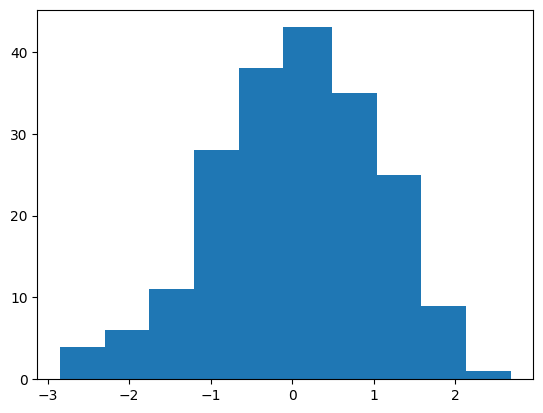

In [15]:
plt.bar(bins_centers, bins_height, width=0.6);

### Выбор числа бинов

Количество бинов гистограммы может сильно повлиять на то как вы приближаете ваше распределение

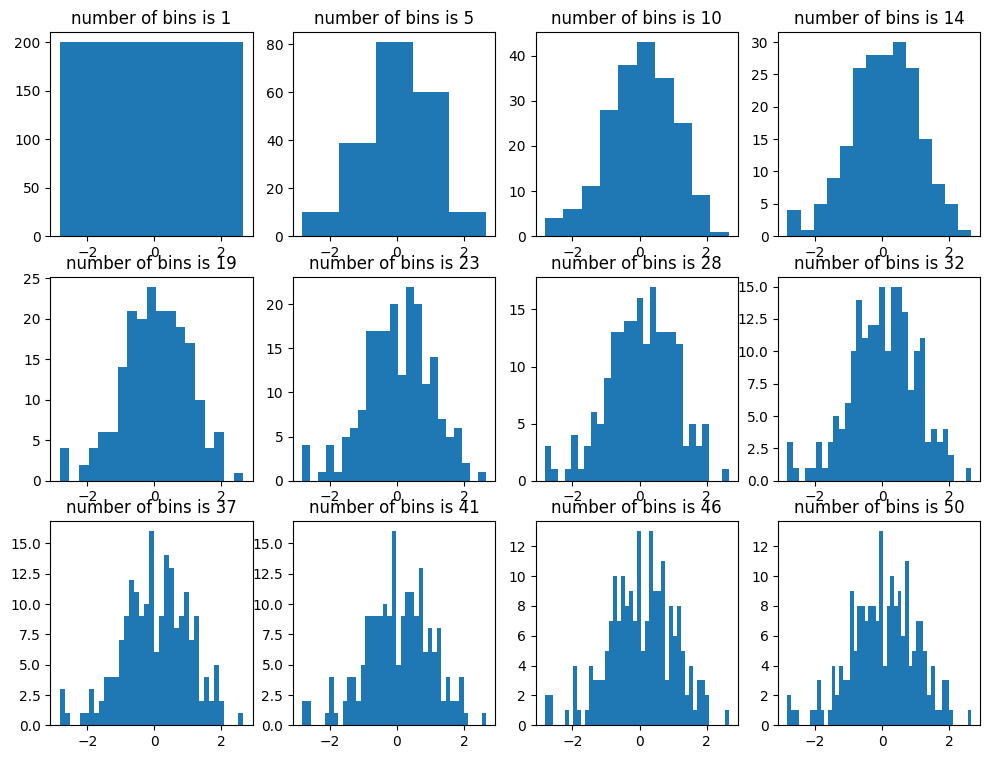

In [16]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
n_bins = np.round(np.linspace(1, 50, 12)).astype(int)

for i, ax in enumerate(axs.flatten()):
    ax.hist(x, bins=n_bins[i])
    ax.set_title(f'number of bins is {n_bins[i]}')

### Метод Freedman–Diaconis 

https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule

Для выбора числа бинов в гистограмме воспользуйте правилом Freedman–Diaconis:

$$\text{Bin width} = 2 \cdot \frac{IQR(x)}{x^{1/3}}$$

Где IQR это inter quartile range, то есть расстояние между 25 и 75 перцентилем распределения.

    3.1 Метод Freedman–Diaconis дает формулу для ширины бина (одинаковая для всех бинов), а чему в таком случае равно число бинов?
    3.2 Имплементируйте функцию для подсчета числа бинов по формуле Freedman–Diaconis

In [41]:
import math
# iqr
def num_of_bins(x):
    iqr = np.quantile(x, 0.75) - np.quantile(x, 0.25)
    
    bi_wi = 2 * iqr / len(x) ** (1./3.) 
    #print("calculate", abs(max(x) - min(x)), bi_wi)
    num_of_bins = abs(max(x) - min(x)) / bi_wi
    
    return round(num_of_bins)
    #return math.floor(num_of_bins)
    #return math.ceil(num_of_bins)
    

In [42]:
print(num_of_bins(x))

12


### В методе `self._best_split` замените перебор всех уникальных трешхолдов на перебор только по уникальным бинам

Количество бинов подбирайте методом Freedman–Diaconis

    3.3 Засеките время обучения вашего регрессора до и после имплементации гистограмм, насколько быстрее стало обучение?
    3.4 Сравните скорость работы вашей имплементации решающего дерева и имплементации sklearn.tree.DecisionTreeRegressor, с аналогичными гиперпараметрами
    3.5 Перечислите другие способы ускорения алгоритма решающего дерева (кроме приближения распределений признаков гистограмми)

In [63]:
from sklearn.tree import DecisionTreeClassifier

model_l = DecisionTreeClassifier(max_depth = 3, min_samples_split = 50)
#model = model.fit(X.values, y.values)

#%load_ext line_profiler

In [54]:
%lprun -f dt._build_tree dt.fit(X.values[:100], y.values[:100])

In [65]:
%lprun -f model_l.fit model_l.fit(X.values[:100], y.values[:100])

# 4. House pricing

воспользуйтесь набором данных из ДЗ2. Обучите алгоритм Решающего дерева (воспользуйтесь имплементацией из sklearn), не забудьте разделить данные на тренировочную и тестовую выборки. 

    4.1. Влияет ли нормировка признаков на алгоритм Решающего дерева? Почему?
    4.2. Переберите различные значения гиперпараметров решающего дерева с использованием функции GridSearchCV, какое наилучшее качество в терминах mean_squared_error вам удалось получить? Насколько это лучше/хуже качества линейных моделей (на том же train-test разбиении).
    4.3. Сравните важность признаков которую предлагает встроенный метод DecisionTreeRegressor().feature_importances_ с важностью признаков полученной для линейных моделей, прокомментируйте.

In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LinearRegression

In [102]:
fd = pd.read_csv('kc_house_data_train.csv', index_col=0)
pd.read_csv('kc_house_data_train.csv', index_col=0).head(3)

X_h = pd.DataFrame()

for i in fd:
    if(i != 'price' and i != 'lat' and i != 'long' and i != 'zipcode' and i != 'date' and i != 'id'):
        X_h[i] = fd[i]
        
        
Y_h = fd['price']

x_train_h, x_test_h, y_train_h, y_test_h = train_test_split(X_h, Y_h, train_size=0.7, random_state=5)

print(X_h)

       bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
21162         4       3.50         3560      6562     2.0           0     0   
16877         3       3.25         4610     81935     2.0           0     0   
16116         4       1.75         1890     10550     1.0           0     0   
9557          2       1.00          840      5510     1.0           0     0   
16302         4       3.50         5550     28078     2.0           0     2   
...         ...        ...          ...       ...     ...         ...   ...   
20147         3       1.50         1420      1192     2.0           0     0   
8294          4       3.25         2885     33671     2.0           0     0   
10406         5       2.25         3260      7969     2.0           0     0   
6701          4       2.50         3100     10000     2.0           0     0   
14811         4       3.00         2570      4000     2.0           0     0   

       condition  grade  sqft_above  sqft_basement 

In [124]:
parameters = {'max_depth': [3, 11, 5] , 'min_samples_split': [40, 43, 37, 29]}

model = DecisionTreeClassifier()
#model.fit(x_train_h, y_train_h)

clf = GridSearchCV(model, parameters)
clf.fit(x_train_h, y_train_h)
#sorted(clf.cv_results_)

/home/ekatrina/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 11, 5],
                         'min_samples_split': [40, 43, 37, 29]})

In [125]:
print(clf.best_params_)

{'max_depth': 3, 'min_samples_split': 40}


In [127]:
model_best = DecisionTreeClassifier(max_depth = 5, min_samples_split = 40)
model_best.fit(x_train_h, y_train_h)

y_pred = model_best.predict(x_test_h)
mse = mean_squared_error(y_test_h, y_pred)
print("treee mse:", mse)

model_R = Ridge()
model_R.fit(x_train_h, y_train_h)
y_test_R = model_R.predict(x_test_h)
mse_test_R = mean_squared_error(y_test_h, y_test_R)
print("mse Ridge =", mse_test_R)

model_L = Lasso()
model_L.fit(x_train_h, y_train_h)
y_test_L = model_L.predict(x_test_h)
mse_test_L = mean_squared_error(y_test_h, y_test_L)
print("mse Lasso =", mse_test_L)

model_LR = LinearRegression()
model_LR.fit(x_train_h, y_train_h)
y_test_LR = model_LR.predict(x_test_h)
mse_test_LR = mean_squared_error(y_test_h, y_test_LR)
print("mse LinReg =", mse_test_LR)

treee mse: 65565615268.50138
mse Ridge = 44608175069.59685
mse Lasso = 44600849101.119354
mse LinReg = 44600692064.984795


/home/ekatrina/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.243e+14, tolerance: 1.378e+11
  model = cd_fast.enet_coordinate_descent(


In [128]:
print(model_best.feature_importances_)

[0.         0.         0.18845626 0.         0.         0.
 0.         0.         0.26405215 0.12741506 0.03302328 0.17492456
 0.02537454 0.11692118 0.06983296]


## Подготовьте репорт о выполненном домашнем задании

Вы можете вставлять в текст таблицы и/или графики на ваше усмотрение, текст репорта не должен превышать 2 страниц 12 кеглем Times New Roman (крайне желательно 1 страница)

Подготовленный репорт и jupyter notebook c вашим решением необходимо отправить на почту kurmukovai@gmail.com, с темой письма [iitp-intro-ds-2023-ha4-Surname], например [iitp-intro-ds-2023-ha4-Kurmukov] до 23:59:59 МСК 26.03.2023.